## MTH9893 Time Series Analysis HW5
* Group 01
* Author: Pan, Hongchao & Sun, Yu
* Kernel version: **R 3.3.2**
* Packages: **dlm, forecast,** readxl, repr
* Data: Adjusted close price of AAPL and SPX over past 5 years
* Notes: 
    * The running time of this notebook is around 7s
    * Please install the packages list above before running the notebook
    * R, sometimes, is tricky: e.g., df_llm[,'Date'] does not work. Thus we change all this coding style to df_llm[['Date']]
    * Workflow of this question:
        * Step1: Get observed values of $\alpha_t, \beta_t$, and variance of $\alpha_t, \beta_t, u_t$
        * Step2: Build Kalman filter based on CAPM model
        * Step3: Compute Kalman filter values and smoothed values of $\alpha_t$
        * Step4: Forecasted values of $\alpha_t$ with 90%/95% probability intervals
    * Installation of required packages has been put at the top of cells
    * References has been put at the end of notebook

In [1]:
# Install required libraries
# Notes: If cannot install package by using function bellow, try 'conda install gcc' first.
# The reason may be caused by gcc complier

#install.packages("dlm")
#install.packages("readxl")
#install.packages("forecast")

In [2]:
# Load libraries
library(readxl)
library(repr)
library(dlm)      # Kalman filter
library(forecast) # Forecasting time series

In [3]:
# Record the total running time of this notebook
# Starting record the time
ptm<-proc.time()

In [4]:
# Read the data from excel file
# Adjusted close price of SPX and AAPL: 
# Cash Adjustment Normal, Cash Adjustment Abnormal, Capital Changes
# Reference: https://cran.r-project.org/web/packages/readxl/readxl.pdf
df<- read_excel("HW5_Data.xlsx",sheet = 1,col_names = TRUE, skip = 1)
colnames(df)<- c('Date','AAPL_Adj_Close','Date2','SPX_Adj_Close')
# Remove redundency date
vars<- c('Date','AAPL_Adj_Close','SPX_Adj_Close')
df_llm<- df[vars]
head(df_llm)

Date,AAPL_Adj_Close,SPX_Adj_Close
2012-03-12,71.5169,1371.09
2012-03-13,73.6028,1395.95
2012-03-14,76.3857,1394.28
2012-03-15,75.8649,1402.60
2012-03-16,75.8662,1404.17
2012-03-19,77.8782,1409.75


Table 1. Overview of AAPL and SPX adjust close price

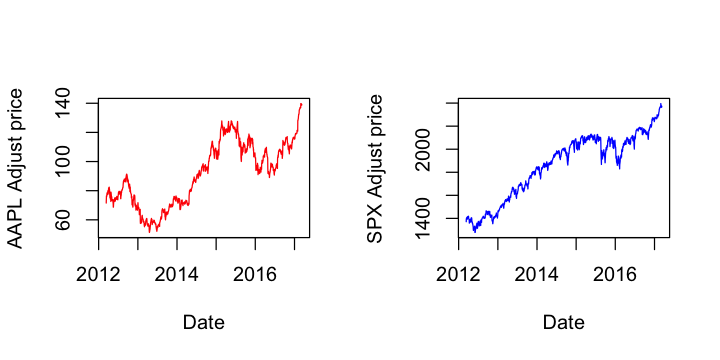

In [5]:
# Plot the data of AAPL and SPX adjust close price
options(repr.plot.height=3, repr.plot.width=6)
par(mfrow = c(1,2))
#plot(x=df_llm[['Date']],y=df_llm[['AAPL_Adj_Close']],type='l',
#    xlab='Date',ylab='AAPL Adjust price',col='red')
# R is tricky, df_llm[['Date']] sometimes does not work
plot(x=df_llm[['Date']],y=df_llm[['AAPL_Adj_Close']],type='l',
    xlab='Date',ylab='AAPL Adjust price',col='red')
plot(df_llm[['Date']],df_llm[['SPX_Adj_Close']],type='l',
     xlab='Date',ylab='SPX Adjust price',col='blue')

Figure 1. Plot of AAPL and SPX adjust close price: no outliers, data is ready for analysis

In [6]:
# Get the returns of AAPL and SPX
AAPL_change<- diff(df_llm[['AAPL_Adj_Close']],differences = 1)/df_llm[(1:(length(df_llm[['Date']])-1)),'AAPL_Adj_Close']
SPX_change<- diff(df_llm[['SPX_Adj_Close']],differences = 1)/df_llm[(1:(length(df_llm[['Date']])-1)),'SPX_Adj_Close']
df_returns<- data.frame(df_llm[(2:length(df_llm[['Date']])),'Date'],AAPL_change,SPX_change)
colnames(df_returns)<- c('Date','AAPL_%change','SPX_%change')
head(df_returns)

Date,AAPL_%change,SPX_%change
2012-03-13,2.916653e-02,0.018131560
2012-03-14,3.780970e-02,-0.001196318
2012-03-15,-6.818030e-03,0.005967238
2012-03-16,1.713572e-05,0.001119350
2012-03-19,2.652037e-02,0.003973878
2012-03-20,8.085703e-03,-0.003000532


Table 2. Overview of AAPL and SPX percentage changes

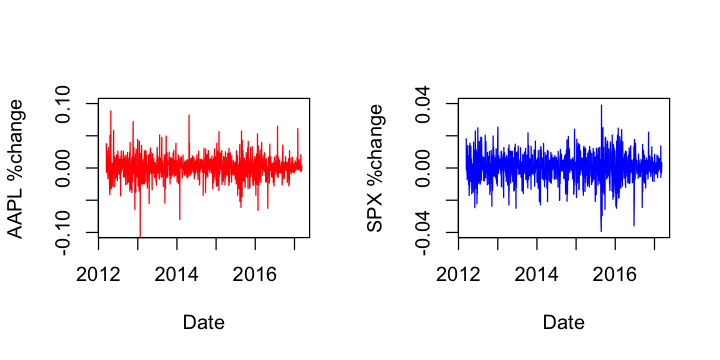

In [7]:
# Plot the data of % change returns
options(repr.plot.height=3, repr.plot.width=6)
par(mfrow = c(1,2))
plot(x=df_returns[['Date']],y=df_returns[['AAPL_%change']],type='l',
    xlab='Date',ylab='AAPL %change',col='red',ylim=c(-0.10,0.10))
plot(x=df_returns[['Date']],y=df_returns[['SPX_%change']],type='l',
    xlab='Date',ylab='SPX %change',col='blue',ylim=c(-0.04,0.04))

Figure 2. The percentage change daily returns of AAPL and SPX

* Note: The percentage change shows as decimal not %, e.g. 0.01, not 0.01%

In [8]:
# Assign the daily return of AAPL as rt, and daily return of SPX as mt
date<- df_returns[['Date']]
rt<- df_returns[['AAPL_%change']]
mt<- df_returns[['SPX_%change']]

In [9]:
# Compute alpha_t and beta_t based on regression
alpha_t<- c()
beta_t<- c()
for (i in 1:(length(rt)-63)){
    # The rolling window contains 63 days (3M)
    res<- lm(rt[i:(i+63)]~mt[i:(i+63)])
    alpha_t<- c(alpha_t, as.numeric(res$coeff[1]))
    beta_t<- c(beta_t,as.numeric(res$coeff[2]))
}

In [10]:
# Get Xt and Yt
Xt<- alpha_t
Yt<- rt[1:length(beta_t)]-(beta_t*mt[1:length(beta_t)])

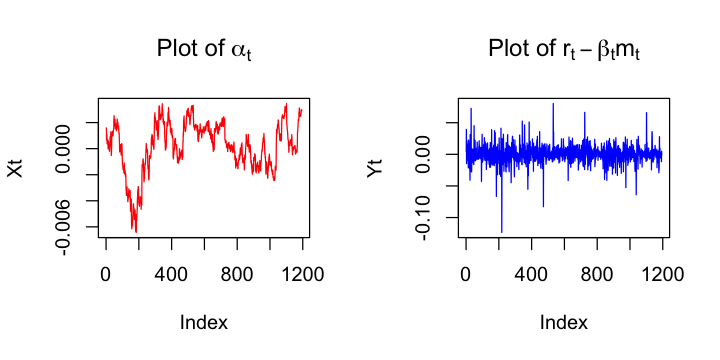

In [11]:
# Plot the data of Xt and Yt
options(repr.plot.height=3, repr.plot.width=6)
par(mfrow = c(1,2))
plot(Xt, type='l',col='red',main=expression(paste("Plot of ",alpha['t'])))
plot(Yt,type='l',col='blue',main=expression(paste("Plot of ",r['t']-beta['t']*'m'['t'])))

Figure 3. Plot of $\alpha_t$ and $r_t-\beta_tm_t$

**Formula the local leverl model with $X_t=\alpha_t$, $Y_t=r_t-\beta_tm_t$**

* Compute the variance of $\epsilon_t$ and $u_t$ from local level model

* Used dlmModReg() function from dlm package to set up CAPM model

* Used dlmMLE() function ftom dlm package to estimate the parameters

* Reference: <sup id="cite_ref-QT_CAPM" class="reference"><a href="#cite_note-QT_CAPM"><span>[</span>1<span>]</span></a></sup> <sup id="cite_ref-SSM" class="reference"><a href="#cite_note-SSM"><span>[</span>2<span>]</span></a></sup> <sup id="cite_ref-SSMinR" class="reference"><a href="#cite_note-SSMinR"><span>[</span>3<span>]</span></a></sup> </sup> <sup id="cite_ref-SSMP" class="reference"><a href="#cite_note-SSMP"><span>[</span>4<span>]</span></a></sup>

dlmModPoly with order 1 will generate a local level model as following </sup> <sup id="cite_ref-SSMP" class="reference"><a href="#cite_note-SSMP"><span>[</span>4<span>]</span></a></sup>:

$$
y_t=\theta_t+v_t \\
\theta_t=\theta_{t-1}+w_t
$$

If we consider $\theta_t$ as $X_t$, $y_t$ as $Y_t$, $v_t$ as $u_t$, and $w_t$ as $\epsilon_t$, then we will have the exact local level model given in the homework. 

Another way to set up the local level model is using dlmModReg() function from scratch of CAPM model</sup> <sup id="cite_ref-SSMP" class="reference"><a href="#cite_note-SSMP"><span>[</span>4<span>]</span></a></sup>.

<img src="TVP_CAPM.png" style="float:center; height: 250px">


**Here, we chose dlmModReg to implement the local level model as following:**

In [12]:
# Compute the variance of sigma and sigma_a and sigma_b from observed data
eXt<- Xt[2:length(Xt)]-Xt[1:(length(Xt)-1)]
ut<- Yt-Xt
ebt<- beta_t[2:length(beta_t)]-beta_t[1:(length(beta_t)-1)]
var_sigma<- var(ut)  # variance of ut
var_alpha<- var(eXt)  # variance of et in alpha_t
var_beta<- var(ebt) # variance of wt in beta_t

paste('Variance of', '$\\sigma^2$,','$\\sigma^2_{\\alpha}$', ' and ','$\\sigma^2_{\\beta}$' , 'from observed data are: ',
    var_sigma, ",", var_alpha,',',var_beta,', respectively.', 
      ' The variances will be the parameters (initial values) of State Space Model MLE estimator.')

[1] "Variance of $\\sigma^2$, $\\sigma^2_{\\alpha}$  and  $\\sigma^2_{\\beta}$ from observed data are:  0.000194080534774814 , 9.84271704956119e-08 , 0.00173687751380074 , respectively.  The variances will be the parameters (initial values) of State Space Model MLE estimator."

In [13]:
# Ref: http://hedibert.org/wp-content/uploads/2015/03/EconometriaAvancada-aula7.pdf P27-P33 of example SPX and IBM
# set parameter restrictions 
#parm_rest <- function(parm){
#    return( exp(parm) ) 
#}
# set up SS model, local level model here
#options(warn = -1) # Ignore the warnings, change value to 0 if wants to show the warning message
ssm <- function(parm,x.mat){
#    parm <- exp(parm)
    return( dlmModReg(X=x.mat, dV=parm[1],dW=c(parm[2],parm[3])) )  
    # dV: variance of the observation noise.
}
# estimate parameters
ssmMLE <- dlmMLE(y=rt,parm=c(var_sigma,var_alpha,var_beta),x.mat=mt,build=ssm,hessian=T)
# c(): pass the observed variances to be the initial value of dV and dW
# Check convergence
cat('The value of MLE convergence: ',ssmMLE$convergence,'\n')
cat('The message of MLE estimator: ',ssmMLE$message)

The value of MLE convergence:  0 
The message of MLE estimator:  CONVERGENCE: REL_REDUCTION_OF_F <= FACTR*EPSMCH

**The value and message shows the MLE was convergent. Thus we can build the model use the parameters from MLE estimator.**

In [14]:
# get residual variance estimate
se2 <- exp(ssmMLE$par)
paste('Variance of', '$\\sigma^2$,','$\\sigma^2_{\\alpha}$', ' and ','$\\sigma^2_{\\beta}$' , 
      'from MLE estimator are: ', se2[1],',',se2[2],',',se2[3])

[1] "Variance of $\\sigma^2$, $\\sigma^2_{\\alpha}$  and  $\\sigma^2_{\\beta}$ from MLE estimator are:  1.00019210324958 , 1.00000009768917 , 1.00173837340426"

In [15]:
# Build the local level model
llm<- ssm(ssmMLE$par,mt)  # Build the model with mt, corresponding x.mat in ssm() function

In [16]:
# Get the Kalman filter value
llmFilter<- dlmFilter(rt,llm) # Filter the value based on rt
# Get the smoothed value
llmSmooth<- dlmSmooth(rt,llm) # Smooth the value based on rt

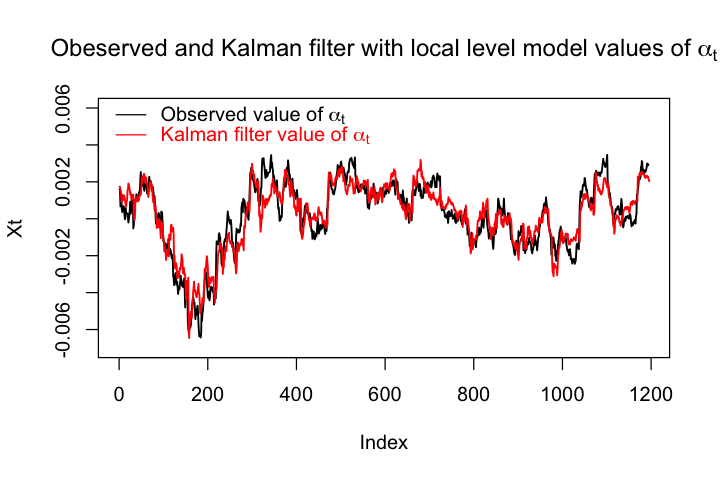

In [17]:
#Plot the Kalman filter value of alpha_t and observed alpha_t
options(repr.plot.height=4, repr.plot.width=6)
plot(Xt,type='l',col='black',lwd = 1.5,ylim = c(-0.007,0.006))
# Notes: 1st column of llmFilter$m is intercept alpha_t, 2nd column is slope beta_t 
# llmFilter$m[63:(length(llmFilter$m[,1])),1] is Kalman filter value of alphat
lines(llmFilter$m[63:(length(llmFilter$m[,1])),1],lty=1,col='red',lwd=1.5)
legend('topleft',c(expression(paste("Observed value of ",alpha['t'])),
                      expression(paste("Kalman filter value of ",alpha['t']))),
      lty=c(1,1),col=c('black','red'),y.intersp=2,
       text.col=c('black','red'),cex=1, inset=0.005,box.col='white')
title(expression(paste("Obeserved and Kalman filter with local level model values of "
                       ,alpha['t'])))

Figure 4. Observed value VS Kalman filter value of $\alpha_t$

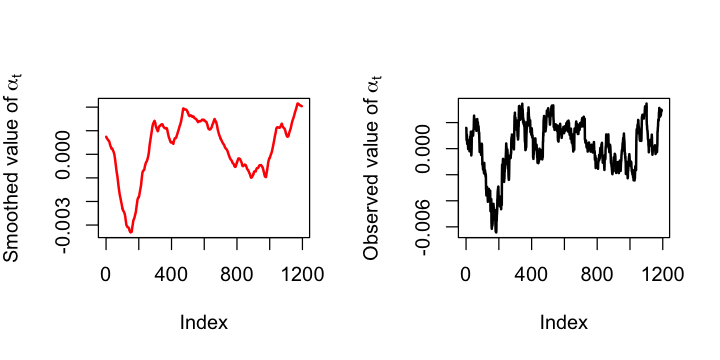

In [18]:
# Plot the smoothed and observed value of alpha_t
options(repr.plot.height=3, repr.plot.width=6)
par(mfrow = c(1,2))
plot(llmSmooth$s[63:(length(llmFilter$m[,1])),1],type='l',lwd=2,
     ylab=expression(paste("Smoothed value of ",alpha['t'])),col='red')
# Similar as alpha_t in Kalman filter, 1st column of llmSmooth$s is smoothed alpha_t
# 2nd column of llmSmooth$s is smoothed beta_t
plot(Xt,type='l',ylab=expression(paste("Observed value of ",alpha['t'])),lwd=2)

Figure 5. Plot of smoothed value (left) and observed value (right) of $\alpha_t$

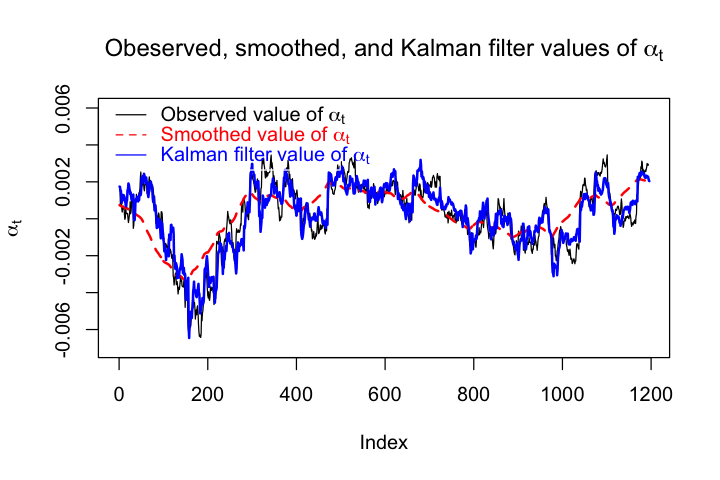

In [19]:
# Plot the smoothed obsered value of alpha_t in one figure
options(repr.plot.height=4, repr.plot.width=6)
plot(Xt,type='l',lwd=1,,ylim = c(-0.007,0.006),ylab=expression(paste(alpha['t'])))
lines(llmSmooth$s[63:(length(llmFilter$m[,1])),1],lty=2,lwd=2,col='red')
lines(llmFilter$m[63:(length(llmFilter$m[,1])),1],lty=1,col='blue',lwd=2)
legend('topleft',c(expression(paste("Observed value of ",alpha['t'])),
                      expression(paste("Smoothed value of ",alpha['t'])),
                  expression(paste("Kalman filter value of ",alpha['t']))),
      lty=c(1,2,1),col=c('black','red','blue'),y.intersp=2,
       text.col=c('black','red','blue'),cex=1, inset=0.005,box.col='white')
title(expression(paste("Obeserved, smoothed, and Kalman filter values of ",alpha['t'])))


Figure 6. Plot of observed values, smoothed values, and Kalman filter values of $\alpha_t$

**Forecat the data in next 10 steps**

* dlmForecast() from dlm package needs constant model, it is not suitable for here.

* Used forecast() function in forecast package for $\alpha_t$  <sup id="cite_ref-SSMinRP5" class="reference"><a href="#cite_note-SSMinRP5"><span>[</span>5<span>]</span></a></sup>

In [20]:
# Forecast the data in next 10 steps
# Since dlmForecast needs constant model, it is not suitable for here
#llmForest<- dlmForecast(llmFilter,nAhead = 10,method = 'plain')
#llmForest

# Used forecast() function in forecast package for alpha_t
llmForecast<- forecast(llmFilter$m[,1],level = c(90,95),h = 10)
llmForecast

     Point Forecast         Lo 90       Hi 90         Lo 95       Hi 95
1259    0.002040178  0.0002845129 0.003795843 -5.182601e-05 0.004132182
1260    0.002040178 -0.0004425831 0.004522939 -9.182143e-04 0.004998570
1261    0.002040178 -0.0010005202 0.005080876 -1.583037e-03 0.005663393
1262    0.002040178 -0.0014708886 0.005551245 -2.143516e-03 0.006223872
1263    0.002040178 -0.0018852941 0.005965650 -2.637311e-03 0.006717667
1264    0.002040178 -0.0022599469 0.006340303 -3.083737e-03 0.007164093
1265    0.002040178 -0.0026044767 0.006684833 -3.494269e-03 0.007574625
1266    0.002040178 -0.0029251578 0.007005514 -3.876385e-03 0.007956741
1267    0.002040178 -0.0032263486 0.007306705 -4.235276e-03 0.008315632
1268    0.002040178 -0.0035112223 0.007591578 -4.574723e-03 0.008655079

Table 3. Forecasted results of Kalman filter $\alpha_t$ with 90% and 95% probability intervals, obtained with *forecast()*

* Another way to forecast the Kalman filter $\alpha_t$ can be done by considering the next 10 steps as missing data <sup id="cite_ref-FORE1" class="reference"><a href="#cite_note-FORE1"><span>[</span>6<span>]</span></a></sup> <sup id="cite_ref-FORE2" class="reference"><a href="#cite_note-FORE2"><span>[</span>7<span>]</span></a></sup>
    * Step 1: Construct an extended time series based on $rt$ with 10 more NA missing data
    * Step 2: Use same model and same Kalman filter for the extended data

In [21]:
# Add 10 NA to the end of rt
nAhead<- 10
rtExt<- rt # copy rt
for (i in 1:nAhead){
    rtExt[length(rtExt)+1]<- NA  # Length of rtExt will add 1 during each loop
}

In [22]:
# Same Kalman filter for extented rt with 10 missing data (NA)
rtExtFilter<- dlmFilter(rtExt,llm)

In [23]:
# Length of extended filter result
nExt<- length(rtExtFilter$m[,1])
cat('Point Forecast values for 10 stpes ahead are: ')
rtExtFilter$m[(nExt-9):nExt,1]

Point Forecast values for 10 stpes ahead are: 

[1] 0.002040175 0.002040175 0.002040175 0.002040175 0.002040175 0.002040175
 [7] 0.002040175 0.002040175 0.002040175 0.002040175

Table 4. Forecasted results of Kalman Filter $\alpha_t$, obtained with method of missing data (extended time series)

** The forecasted values of two methods are convergent. Thus we used forecasted values with 90% and 95% probability intervals for further analysis** <sup id="cite_ref-col" class="reference"><a href="#cite_note-col"><span>[</span>8<span>]</span></a></sup>

In [24]:
# Get the forecasted values
foreX<-c()
for (i in 1: nAhead){
    foreX<- c(foreX, length(llmFilter$m[63:(length(llmFilter$m[,1])),1])+i) # index of forecasted values
}
foreP<- as.numeric(llmForecast$mean)
foreU90<- as.numeric(llmForecast$upper[,1])  # Upper level of 90% probability interval
foreU95<- as.numeric(llmForecast$upper[,2])  # Upper level of 95% probability interval
foreD90<- as.numeric(llmForecast$lower[,1])  # Lower level of 90% probability interval
foreD95<- as.numeric(llmForecast$lower[,2])  # Lower level of 95% probability interval

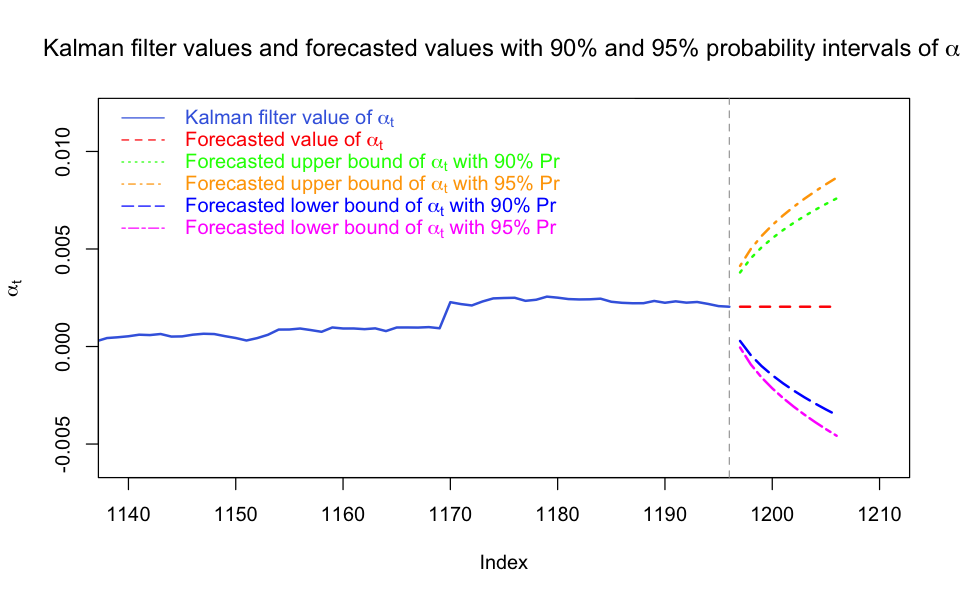

In [25]:
# Plot the Kalman filter alpha_t and forecasted alpha_t
options(repr.plot.height=5, repr.plot.width=8)
plot(llmFilter$m[63:(length(llmFilter$m[,1])),1],type='l',col='royalblue',
     lwd=2,xlim=c(1140,1210),ylim=c(-0.006,0.012),ylab=expression(paste(alpha['t'])))
abline(v=(foreX[1]-1),col='darkgrey',lty='dashed')
lines(foreX,foreP,lty=2,pch=19,col='red',lwd=2)
lines(foreX,foreU90,lty=3,col='green',lwd=2)
lines(foreX,foreU95,lty=4,col='orange',lwd=2)
lines(foreX,foreD90,lty=5,col=rainbow(6)[5],lwd=2)
lines(foreX,foreD95,lty=6,col=rainbow(6)[6],lwd=2)
legend('topleft',c(expression(paste("Kalman filter value of ",alpha['t'])),
                   expression(paste("Forecasted value of ",alpha['t'])),
                   expression(paste("Forecasted upper bound of ",alpha['t'],' with 90% Pr')),
                   expression(paste("Forecasted upper bound of ",alpha['t'],' with 95% Pr')),
                   expression(paste("Forecasted lower bound of ",alpha['t'],' with 90% Pr')),
                   expression(paste("Forecasted lower bound of ",alpha['t'],' with 95% Pr'))),
       lty=c(1,2,3,4,5,6),col=c('royalblue','red','green','orange',rainbow(6)[5],rainbow(6)[6]),
       y.intersp=1.5,text.col=c('royalblue','red','green','orange',rainbow(6)[5],rainbow(6)[6]),
       cex=1, inset=0.003,box.col='white')
title(expression(paste("Kalman filter values and forecasted values with 90% and 95% probability intervals of ",alpha['t'])))


Figure 7. Kalman filter values and forecasted values with 90% and 95% probability intervals of $\alpha_t$

### Observations and Notes

* The Kalman filter used in this notebook based on CAPM model and local level model 
<br>

* The Kalman filter values looks good fit of observed $\alpha_t$, and the smoothed values of Kalman filter $\alpha_t$ looks good. The figures looks similar to the Figure 3 in reference # 3.
<br>

* The forecasted values based on two methods are constistent and look good. Figure 7 also shows the forecasted values with different probability intervals (90% and 95%). 
<br>

* The results of filtered, smoothed, and forecasted values imply that the setted model is good for fitting observed $\alpha_t$.

### References

<br />

<div class="reflist" style="list-style-type: decimal;">

<ol>


    <li id="cite_note-QT_CAPM"><span class="mw-cite-backlink"><b><a href="#cite_ref-QT_CAPM">^</a></b></span> Linear State Space Linear Models, and Kalman Filters, 
<span>* Quantitative Thoughts*</span>, http://lalas.github.io/quantitativeThoughts/r/2014/09/01/dlmTutorial.html#topic6.1.</li>

  <li id="cite_note-SSM"><span class="mw-cite-backlink"><b><a href="#cite_ref-SSM">^</a></b></span>   https://sites.ualberta.ca/~sfossati/e509/files/other/dlm_ex.R <span></li>
  
  
    <li id="cite_note-SSMinR"><span class="mw-cite-backlink"><b><a href="#cite_ref-SSMinR">^</a></b></span>   State Space Model in R,
<span>* Journal of Statistical Software*</span>,  <span>**41**</span> 1-25 (2011). <span>https://www.jstatsoft.org/article/view/v041i04/v41i04.pdf</span></li>

    <li id="cite_note-SSMP"><span class="mw-cite-backlink"><b><a href="#cite_ref-SSMP">^</a></b></span> http://hedibert.org/wp-content/uploads/2015/03/EconometriaAvancada-aula7.pdf, <span>*Hedibert Freitas Lopes*, </span> <span>22-30</span> </li>
    
    <li id="cite_note-SSMinRP5"><span class="mw-cite-backlink"><b><a href="#cite_ref-SSMinRP5">^</a></b></span>   State Space Model in R,
<span>* Journal of Statistical Software*, </span>P4-5,  <span>**41**</span> 1-25 (2011). <span>https://www.jstatsoft.org/article/view/v041i04/v41i04.pdf</span></li>

    <li id="cite_note-FORE1"><span class="mw-cite-backlink"><b><a href="#cite_ref-FORE1">^</a></b></span>   State space models and Kalman filtering,
<span>* Time Series Analysis (Lecture notes 5), Andrew Lesniewski*, </span>P24-30</li>

    <li id="cite_note-FORE2"><span class="mw-cite-backlink"><b><a href="#cite_ref-FORE2">^</a></b></span>   Forcasting using Kalman Filter,
<span>http://lalas.github.io/quantitativeThoughts/r/2014/09/01/dlmTutorial.html#topic6.1</span></li>

<li id="cite_note-col"><span class="mw-cite-backlink"><b><a href="#cite_ref-col">^</a></b></span>   Color names in R,
<span>http://www.stat.columbia.edu/~tzheng/files/Rcolor.pdf</span></li>
       
</ol>

In [26]:
# End recording the running time
cat('The running time of this notebooks is: ')
proc.time()-ptm

The running time of this notebooks is: 

   user  system elapsed 
  6.068   0.195   6.760 